# Hands-on introduction to ML training
In this notebook we will tackle a different kind of problem: Classification

In this lesson, we will also use one-hot encoding, something we learnt about in the previous lesson.

### Step 1: Load and explore data
The first step is figuring out the data source. In this case we will use a pre-existing dataset. We will:
1. Create a folder 'data'
2. Download the file from public github repo using python package "requests" and save the `titanic.csv` file in the data folder.

In [36]:
%config IPCompleter.greedy=True #Helps with auto-complete

import numpy as np
import pandas as pd
import os

try:
    os.mkdir('data')
except OSError as error:
    print(error)

import requests, csv

url = 'https://raw.githubusercontent.com/techno-nerd/ML_Course/main/04%20Classification/data/titanic.csv'
r = requests.get(url)
with open('data/titanic.csv', 'w') as f:
  writer = csv.writer(f)
  for line in r.iter_lines():
    writer.writerow(line.decode('utf-8').split(','))

[Errno 17] File exists: 'data'


In [37]:
df = pd.read_csv('data/titanic.csv')

In [38]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.0,3.0,Braund Mr. Owen Harris,male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2.0,1.0,1.0,Cumings Mrs. John Bradley (Florence Briggs Tha...,female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3.0,1.0,3.0,Heikkinen Miss. Laina,female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4.0,1.0,1.0,Futrelle Mrs. Jacques Heath (Lily May Peel),female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5.0,0.0,3.0,Allen Mr. William Henry,male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [39]:
print(df['Survived'].value_counts())
#0 = Died, 1 = Survived

Survived
0.0    549
1.0    342
Name: count, dtype: int64


### Visualising the distribution of rows for some of the features

<Axes: >

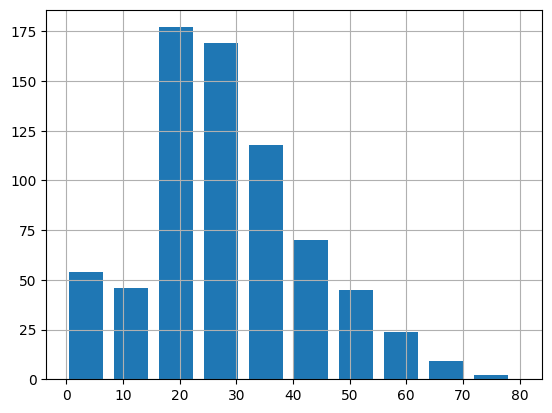

In [40]:
df['Age'].hist(width=6)

<Axes: xlabel='Pclass'>

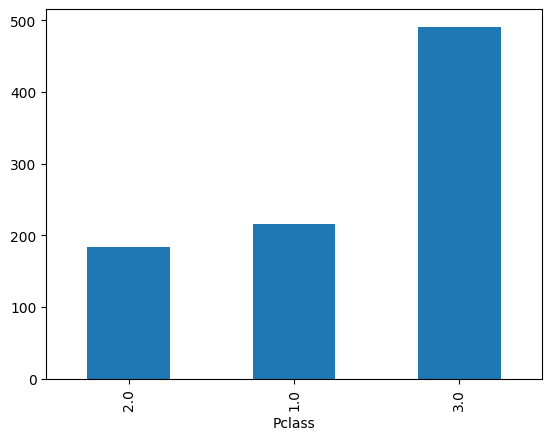

In [41]:
df['Pclass'].value_counts().sort_values().plot(kind='bar')

### Now, we are looking at the distribution of people who survived across a few different features to determine their importance

In [42]:
#Function returns the stats for survived (1) vs died (0) for a given variable (column)

def survival_stats(variable):
    Died = df[df["Survived"]==0][variable].value_counts()
    Survived = df[df["Survived"]==1][variable].value_counts()

    data = pd.DataFrame([Died, Survived])
    data.index=["No", "Yes"]
    return data.head()

In [43]:
survival_stats('Sex')

Sex,male,female
No,468,81
Yes,109,233


In [44]:
survival_stats('Embarked')

Embarked,S,C,Q
No,427,75,47
Yes,217,93,30


### Step 2: Data preparation

There are a few tasks we need to do before we can train the model on this data:
1. Get rid of null values 
2. Replace string values like 'male' and 'female' with integers (0 and 1)
3. Handle categorical values for Embarked
4. Drop unnecessary columns like Name 

Then, we will split the data the same way as last time:
1. Split the data (181 rows) into training set (80%) and test set (20%)
2. Separate the input features ("GPA") from target variable ("SAT Score")

In [45]:
#Missing values
print(f"Total Passengers: {df.shape[0]}")
for i in df.columns:
    print(f"{i}: {sum(df[i].isnull())}")

Total Passengers: 893
PassengerId: 2
Survived: 2
Pclass: 2
Name: 2
Sex: 2
Age: 179
SibSp: 2
Parch: 2
Ticket: 2
Fare: 2
Cabin: 689
Embarked: 4


In [46]:
df['Sex'].replace({'male':1, 'female':0}, inplace=True)

In [47]:
print(df['Sex'].value_counts())

Sex
1.0    577
0.0    314
Name: count, dtype: int64


In [48]:
#Deleting all rows with missing values (except cabin, as that column will be removed)
df.dropna(subset=['Age', 'Embarked'], inplace=True)
print(df.shape[0])

712


In [49]:
print(df.dtypes)

PassengerId    float64
Survived       float64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [50]:
#All non-numeric features need to be ignored (embarked and class will be added to features later after being one-hot encoded)

features = df[['Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
features[:5]

,Sex,Age,SibSp,Parch,Fare
0,1.0,22.0,1.0,0.0,7.2500
1,0.0,38.0,1.0,0.0,71.2833
2,0.0,26.0,0.0,0.0,7.9250
3,0.0,35.0,1.0,0.0,53.1000
4,1.0,35.0,0.0,0.0,8.0500


In [51]:
#One_hot encoding Passenger class
one_hot_class = pd.get_dummies(df['Pclass'])
features = features.join(one_hot_class)

features[:2]

,Sex,Age,SibSp,Parch,Fare,1.0,2.0,3.0
0,1.0,22.0,1.0,0.0,7.2500,False,False,True
1,0.0,38.0,1.0,0.0,71.2833,True,False,False


In [52]:
#One_hot encoding Embarked point
one_hot_embark = pd.get_dummies(df['Embarked'])
features = features.join(one_hot_embark)

features[:2]

,Sex,Age,SibSp,Parch,Fare,1.0,2.0,3.0,C,Q,S
0,1.0,22.0,1.0,0.0,7.2500,False,False,True,False,False,True
1,0.0,38.0,1.0,0.0,71.2833,True,False,False,True,False,False


In [53]:
print(features.dtypes)

Sex      float64
Age      float64
SibSp    float64
Parch    float64
Fare     float64
1.0         bool
2.0         bool
3.0         bool
C           bool
Q           bool
S           bool
dtype: object


In [54]:
for colName in features.columns:
    if features[colName].dtype == bool:
        print(colName)
        features[colName].replace({False:0, True:1}, inplace=True)

1.0
2.0
3.0
C
Q
S


In [55]:
print(features.dtypes)

Sex      float64
Age      float64
SibSp    float64
Parch    float64
Fare     float64
1.0        int64
2.0        int64
3.0        int64
C          int64
Q          int64
S          int64
dtype: object


In [56]:
features.columns = features.columns.astype(str)
print(features.columns)

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', '1.0', '2.0', '3.0', 'C', 'Q',
       'S'],
      dtype='object')


In [57]:
import sklearn.model_selection as ms

labels = df['Survived']

train_features, test_features, train_labels, test_labels = ms.train_test_split(features, labels, test_size=0.2)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(569, 11)
(143, 11)
(569,)
(143,)


### Step 3: Model Selection and Training

For this problem, we will use a model called logistic regression. The image below illustrates the difference between linear and logistic regression. 

![Linear vs Logistic Regression](https://raw.githubusercontent.com/techno-nerd/ML_101_Course/main/04%20Classification/resources/logit.png)

To learn more, watch the video: https://youtu.be/O4sExG-hUxA

This model also learns weights for each feature, just like a linear regression model. But,  it applies a function at the end that maps the value between 0 and 1.

In [58]:
from sklearn import linear_model as lm

logistic_mod = lm.LogisticRegression(solver='lbfgs', max_iter=500)
logistic_mod.fit(train_features, train_labels)

print(logistic_mod.coef_)
print(logistic_mod.intercept_)

[[-2.2784038  -0.03835513 -0.32951366  0.0419414   0.00241814  1.11385919
  -0.03256043 -1.07736195  0.41140688 -0.29344707 -0.11402301]]
[2.44288466]


Output of Logistic Regression model is between 0 and 1<br>

It is the probability of "label = 1". E.g. if the output is 0.8, it means there is an 80% probability that the person will "survive" (label = 1) and 20% probability that the person will "die" (label = 0)

In [59]:
train_probs = logistic_mod.predict_proba(train_features)
test_probs = logistic_mod.predict_proba(test_features)

In [60]:
print('Class 0 (Died) and Class 1 (Survived) probabilities')
print(train_probs[:5])

Class 0 (Died) and Class 1 (Survived) probabilities
[[0.38292908 0.61707092]
 [0.35895366 0.64104634]
 [0.86390473 0.13609527]
 [0.85024939 0.14975061]
 [0.04572932 0.95427068]]


### Step 4: Model evaluation and tuning
Unlike linear regression, we are not going to use Root Mean Squared Error. Instead, we will use three metrics:
1. Accuracy = total correct / total predictions
2. Precision = correct class 1 / total predicted class 1
3. Recall = correct class 1 / total number of class 1's


In [61]:
#Here, we are saying that whenever the confidence is above 50%, consider the value to be 1, otherwise 0. 50% (0.5) here is called the threshold.

train_pred = np.where(train_probs[:, 1] > 0.5, 1, 0)
test_pred = np.where(test_probs[:, 1] > 0.5, 1, 0)

In [62]:
def ClassifierMetrics(labels, predictions):
    total = labels.size
    result = (labels == predictions)
    correct = result.sum()
    accuracy = (correct)/total

    #Precision (correct '1' prediction / total '1' prediction)
    precision = (result[predictions == 1.0].sum()) / (predictions == 1.0).sum()

    #Recall = (correct '1' predictions / total number of '1's)

    recall = (result[predictions == 1.0].sum()) / (labels == 1.0).sum()

    return [accuracy, precision, recall]

In [63]:
train_metrics = ClassifierMetrics(train_labels, train_pred)
print("TRAIN Metrics:")
print(f"Accuracy: {np.round(train_metrics[0]*100, 2)}%")
print(f"Precision: {np.round(train_metrics[1]*100, 2)}%")
print(f"Recall: {np.round(train_metrics[2]*100, 2)}%")

TRAIN Metrics:
Accuracy: 79.44%
Precision: 77.46%
Recall: 70.51


In [64]:
test_metrics = ClassifierMetrics(test_labels, test_pred)
print("TEST Metrics:")
print(f"Accuracy: {np.round(test_metrics[0]*100, 2)}%")
print(f"Precision: {np.round(test_metrics[1]*100, 2)}%")
print(f"Recall: {np.round(test_metrics[2]*100, 2)}%")

TEST Metrics:
Accuracy: 84.62%
Precision: 82.0%
Recall: 75.93%


### Precision and Recall

The precision and recall can be fine-tuned by adjusting the threshold (0.5 for this example). Typically, higher the threshold, higher the precision and lower the recall.

Precision is important for problems like facial recognition, where false positives can be a major security risk.

Recall is important for problems like medical diagnosis, where true negatives can leave dangerous conditions untreated. 

In [65]:
#For comparison, here is how a linear regression model would perform

from sklearn.linear_model import LinearRegression

linear_mod = LinearRegression()
linear_mod = linear_mod.fit(train_features, train_labels)

In [66]:
train_probs_ln = linear_mod.predict(train_features)
test_probs_ln = linear_mod.predict(test_features)

In [67]:
#Here, we are saying that whenever the confidence is above 50%, consider the value to be 1, otherwise 0. 50% (0.5) here is called the threshold.

train_pred_ln = np.where(train_probs_ln[:] > 0.5, 1, 0)
test_pred_ln = np.where(test_probs_ln[:] > 0.5, 1, 0)

In [68]:
test_metrics_ln = ClassifierMetrics(test_labels, test_pred_ln)
print("TEST Metrics:")
print(f"Accuracy: {np.round(test_metrics_ln[0]*100, 2)}%")
print(f"Precision: {np.round(test_metrics_ln[1]*100, 2)}%")
print(f"Recall: {np.round(test_metrics_ln[2]*100, 2)}%")

TEST Metrics:
Accuracy: 82.52%
Precision: 77.36%
Recall: 75.93%


As you can see, Linear Regression is not a bad choice for this problem. However, this will not hold true for more complex problems.

To learn more about why Logistic Regression is used instead, watch this [video](https://www.youtube.com/watch?v=O4sExG-hUxA&list=PLQgiAnE0yKhdxtPdPeinKnuS2Qt4wEein&index=4)
